In [1]:
# 1. Install (Run once)
!pip install torchxrayvision --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.0/29.0 MB 41.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 90.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 73.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 46.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 34.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 79.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour i

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import itertools
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
import torchxrayvision as xrv

In [3]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [4]:
# A. For Custom CNN, AlexNet, TorchXRayVision (1 Channel)
transform_gray = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# B. For DenseNet121 ImageNet (3 Channels + Normalization)
transform_rgb = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=3), # Convert to 3 channels
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [5]:
test_dir = '/kaggle/input/koa-xray/XRAY/test' 
BATCH_SIZE = 32

# Load Datasets
dataset_gray = datasets.ImageFolder(root=test_dir, transform=transform_gray)
loader_gray = DataLoader(dataset_gray, batch_size=32, shuffle=False, num_workers=2)

dataset_rgb = datasets.ImageFolder(root=test_dir, transform=transform_rgb)
loader_rgb = DataLoader(dataset_rgb, batch_size=32, shuffle=False, num_workers=2)

print(f"Test Data Loaded. Samples: {len(dataset_gray)}")

Test Data Loaded. Samples: 1659


## Model Defination

In [6]:
class CustomCNN(nn.Module):
    def __init__(self, num_classes=5):
        super(CustomCNN, self).__init__()
        self.block1 = nn.Sequential(nn.Conv2d(1, 32, 3, padding=1), nn.ReLU(), nn.Conv2d(32, 32, 3, padding=1), nn.ReLU(), nn.BatchNorm2d(32), nn.MaxPool2d(2, 2), nn.Dropout(0.25))
        self.block2 = nn.Sequential(nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(), nn.Conv2d(64, 64, 3, padding=1), nn.ReLU(), nn.BatchNorm2d(64), nn.MaxPool2d(2, 2), nn.Dropout(0.30))
        self.block3 = nn.Sequential(nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(), nn.Conv2d(128, 128, 3, padding=1), nn.ReLU(), nn.BatchNorm2d(128), nn.MaxPool2d(2, 2), nn.Dropout(0.35))
        self.block4 = nn.Sequential(nn.Conv2d(128, 256, 3, padding=1), nn.ReLU(), nn.Conv2d(256, 256, 3, padding=1), nn.ReLU(), nn.BatchNorm2d(256), nn.MaxPool2d(2, 2), nn.Dropout(0.40))
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.classifier = nn.Sequential(nn.Flatten(), nn.Linear(256, 512), nn.ReLU(), nn.BatchNorm1d(512), nn.Dropout(0.5), nn.Linear(512, num_classes))

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        x = self.global_avg_pool(x)
        x = self.classifier(x)
        return x

def get_alexnet(num_classes=5):
    # Initialize standard AlexNet structure
    model = models.alexnet(weights=None)
    num_ftrs = model.classifier[6].in_features
    model.classifier[6] = nn.Linear(num_ftrs, num_classes)
    return model

def get_densenet(num_classes=5):
    model = models.densenet121(weights=None) 
    num_ftrs = model.classifier.in_features
    model.classifier = nn.Linear(num_ftrs, num_classes)
    return model

def get_txv_model(num_classes=5):
    model = xrv.models.DenseNet(weights="densenet121-res224-all") # Keep weights to ensure architecture match
    model.op_threshs = None
    num_ftrs = model.classifier.in_features
    model.classifier = nn.Linear(num_ftrs, num_classes)
    return model

# --- LOADING FUNCTIONS ---
def load_weights(model, path):
    if os.path.exists(path):
        print(f"Loading {path}...")
        try:
            model.load_state_dict(torch.load(path, map_location=device))
            print("  -> Success!")
            return model.to(device)
        except Exception as e:
            print(f"  -> FAILED: {e}")
            return None
    else:
        print(f"Warning: {path} not found!")
        return None

In [7]:
def evaluate_and_plot(model, dataloader, model_name):
    if model is None: return None
    
    print(f"\n--- Evaluating {model_name} ---")
    model.eval()
    y_true = []
    y_pred = []
    
    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            y_true.extend(labels.numpy())
            y_pred.extend(preds.cpu().numpy())
            
    # Metrics
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='macro')
    
    print(f"Accuracy: {acc:.4f}")
    print(classification_report(y_true, y_pred, digits=4))
    
    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(f"{model_name} (Acc: {acc:.2%})")
    plt.colorbar()
    classes = ['0', '1', '2', '3', '4']
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)
    
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
        
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    
    return {'Model': model_name, 'Accuracy': acc, 'Macro F1': f1}

Loading /kaggle/input/models/best_custom_cnn.pth...
  -> Success!

--- Evaluating Custom CNN ---
Accuracy: 0.6655
              precision    recall  f1-score   support

           0     0.7215    0.7991    0.7583       642
           1     0.3679    0.2635    0.3071       296
           2     0.6416    0.6689    0.6550       447
           3     0.8325    0.7578    0.7934       223
           4     0.6716    0.8824    0.7627        51

    accuracy                         0.6655      1659
   macro avg     0.6470    0.6743    0.6553      1659
weighted avg     0.6503    0.6655    0.6548      1659



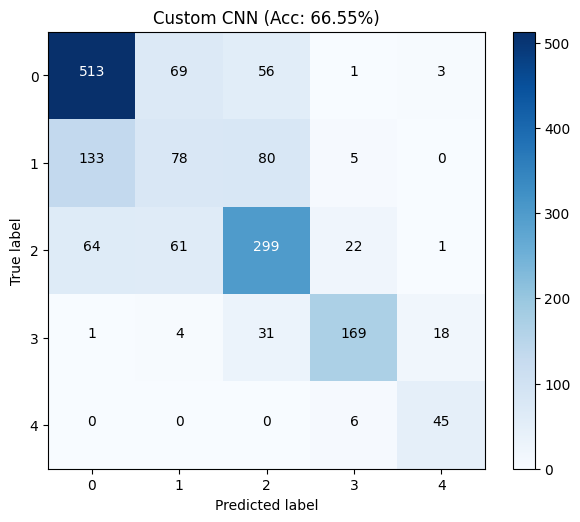

Loading /kaggle/input/models/best_alexnet_finetuned.pth...
  -> Success!

--- Evaluating AlexNet ---
Accuracy: 0.5672
              precision    recall  f1-score   support

           0     0.6397    0.7773    0.7018       642
           1     0.2794    0.2973    0.2881       296
           2     0.5908    0.4004    0.4773       447
           3     0.6553    0.6054    0.6294       223
           4     0.7273    0.7843    0.7547        51

    accuracy                         0.5672      1659
   macro avg     0.5785    0.5729    0.5703      1659
weighted avg     0.5670    0.5672    0.5594      1659



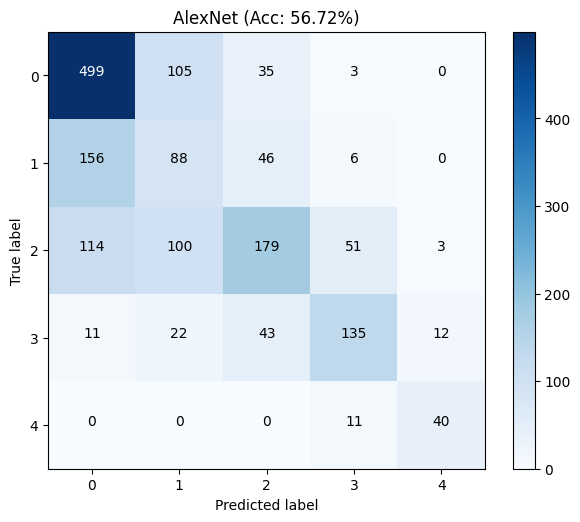

Loading /kaggle/input/models/best_densenet_finetuned.pth...
  -> Success!

--- Evaluating DenseNet121 (ImageNet) ---
Accuracy: 0.5630
              precision    recall  f1-score   support

           0     0.6425    0.7445    0.6898       642
           1     0.2639    0.2568    0.2603       296
           2     0.5722    0.4519    0.5050       447
           3     0.6524    0.6143    0.6328       223
           4     0.6406    0.8039    0.7130        51

    accuracy                         0.5630      1659
   macro avg     0.5543    0.5743    0.5602      1659
weighted avg     0.5573    0.5630    0.5564      1659



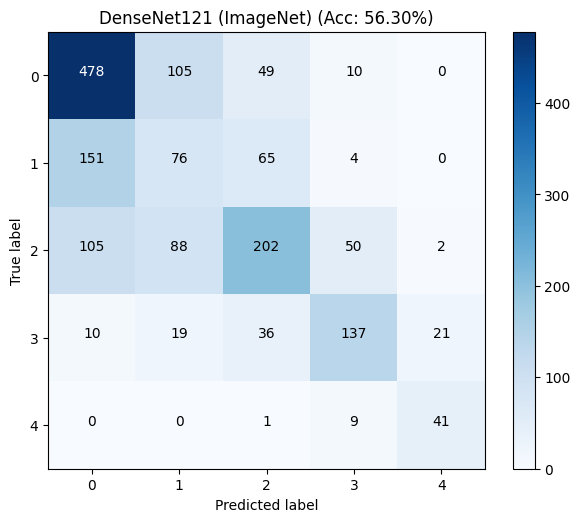

If this fails you can run `wget https://github.com/mlmed/torchxrayvision/releases/download/v1/nih-pc-chex-mimic_ch-google-openi-kaggle-densenet121-d121-tw-lr001-rot45-tr15-sc15-seed0-best.pt -O /root/.torchxrayvision/models_data/nih-pc-chex-mimic_ch-google-openi-kaggle-densenet121-d121-tw-lr001-rot45-tr15-sc15-seed0-best.pt`
[██████████████████████████████████████████████████]
Loading /kaggle/input/models/best_txv_finetuned (1).pth...
  -> Success!

--- Evaluating TorchXRayVision ---
Accuracy: 0.4521
              precision    recall  f1-score   support

           0     0.4939    0.8769    0.6319       642
           1     0.2289    0.0642    0.1003       296
           2     0.3604    0.1790    0.2392       447
           3     0.3960    0.2646    0.3172       223
           4     0.4462    0.5686    0.5000        51

    accuracy                         0.4521      1659
   macro avg     0.3851    0.3907    0.3577      1659
weighted avg     0.3960    0.4521    0.3849      1659



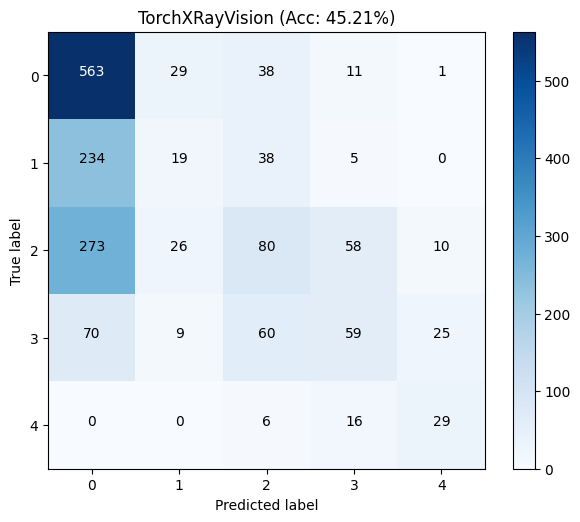


=== FINAL LEADERBOARD ===
                    Model  Accuracy  Macro F1
0              Custom CNN  0.665461  0.655305
1                 AlexNet  0.567209  0.570260
2  DenseNet121 (ImageNet)  0.562990  0.560173
3         TorchXRayVision  0.452080  0.357701


In [8]:
results = []

# 1. Custom CNN (Grayscale)
model_cnn = CustomCNN(5)
model_cnn = load_weights(model_cnn, '/kaggle/input/models/best_custom_cnn.pth')
res = evaluate_and_plot(model_cnn, loader_gray, "Custom CNN")
if res: results.append(res)

# 2. AlexNet (Grayscale)
model_alex = get_alexnet(5)
model_alex = load_weights(model_alex, '/kaggle/input/models/best_alexnet_finetuned.pth')
res = evaluate_and_plot(model_alex, loader_rgb, "AlexNet")
if res: results.append(res)

# 3. DenseNet ImageNet (RGB + Normalized) <-- CRITICAL: Uses loader_rgb
model_dense = get_densenet(5)
model_dense = load_weights(model_dense, '/kaggle/input/models/best_densenet_finetuned.pth')
res = evaluate_and_plot(model_dense, loader_rgb, "DenseNet121 (ImageNet)")
if res: results.append(res)

# 4. TorchXRayVision (Grayscale)
model_txv = get_txv_model(5)
model_txv = load_weights(model_txv, '/kaggle/input/models/best_txv_finetuned (1).pth')
res = evaluate_and_plot(model_txv, loader_gray, "TorchXRayVision")
if res: results.append(res)

# Final Comparison
if results:
    df = pd.DataFrame(results).sort_values(by='Macro F1', ascending=False)
    print("\n=== FINAL LEADERBOARD ===")
    print(df)